# Мешок слов и классификация текстов
## ДЗ 4 Анна Клезович

Первую часть тетрадки с импорт всего и загрузкой labeled.csv я оставляю как есть. Это понадобится мне для 2-ого задания.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

from IPython.display import Image
from IPython.core.display import HTML 

In [100]:
data = pd.read_csv('labeled.csv')

In [124]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


В определении тональности токсичных текстов обычно значительно меньше. Дисбаланс классов может сильно влиять на качество модели, но сделать с ним практически ничего нельзя (можно пробовать выкинуть часть мажорного класса) 

In [125]:
data.toxic.value_counts(normalize=True)

0.0    0.66514
1.0    0.33486
Name: toxic, dtype: float64

Для того, чтобы понять качество обученной модели нам нужно разделить данные на обучающую и тестовую выборку.

In [103]:
#train, test = train_test_split(data, test_size=0.1, shuffle=True)
#train.reset_index(inplace=True)
#test.reset_index(inplace=True)

### Векторизация текста

Базовый способ векторизовать текст описывается метафорой "мешок слов" (bag-of-words). Чтобы векторизовать некоторый набор документов (=текстов) мешком слов нужно: а) составить словарь всех уникальных слов, встречаемых в этих документах б) посчитать частотность каждого слова в каждом из документов в) зафиксировать порядок слов в словаре и составить для каждого документа вектор размерности N (N - размер словаря), где по индексу i стоит частота слова w_i в этом документе. 

Вот картинка для наглядности:

In [7]:
Image(url="https://i.ibb.co/r5Nc2HC/abs-bow.jpg",
     width=500, height=500)

In [51]:
texts = ["я и ты", "ты и я", "я, я и только я", "только не я", "он"]

all_words = ' '.join(texts)
unique_words = list(set([word.strip(',.!?') for word in all_words.split()]))
unique_words

['ты', 'не', 'только', 'и', 'он', 'я']

In [52]:
[[0 for el in range(len(unique_words))] for k in range(len(texts))]

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0]]

In [97]:
df = pd.DataFrame([[0 for j in range(len(unique_words))] for k in range(len(texts))],
    columns=unique_words,
    index=texts)
print(df)

for i, text in enumerate(texts):
    for word in text.split():
        word = word.strip(',.!?')
        df[word][i] += 1
df = df.astype(float)
df

                 ты  не  только  и  он  я
я и ты            0   0       0  0   0  0
ты и я            0   0       0  0   0  0
я, я и только я   0   0       0  0   0  0
только не я       0   0       0  0   0  0
он                0   0       0  0   0  0


,ты,не,только,и,он,я
я и ты,1.0,0.0,0.0,1.0,0.0,1.0
ты и я,1.0,0.0,0.0,1.0,0.0,1.0
"я, я и только я",0.0,0.0,1.0,1.0,0.0,3.0
только не я,0.0,1.0,1.0,0.0,0.0,1.0
он,0.0,0.0,0.0,0.0,1.0,0.0


CountVectorizer в sklearn векторизует как раз таким образом

In [9]:
vectorizer = CountVectorizer()
# в векторайзер нужно засовывать тексты строками (токенизация там встроена)
X = vectorizer.fit_transform(train.comment)

Еще вместо нормазиванных частот можно использовать tf-idf (term frequency - inverse document frequency). 

Кратко про tfidf на картинке.

Задание 1 для домашней работы, я делала по формуле с картинки.

In [10]:
Image(url="https://miro.medium.com/max/3604/1*qQgnyPLDIkUmeZKN2_ZWbQ.png",
     width=500, height=500)

In [98]:
import math

print(df)
n = len(texts)
for term in df:
    doc_freq = float(len(df[df[term] != 0]))
    for i, doc in enumerate(texts):
        # num_words_in_text = len(texts[i].split())
        tf = df[term][i]  # / float(num_words_in_text)
        idf = math.log((1 + n) / (1 + doc_freq)) + 1
        tfidf = tf * idf
        print(tfidf)
        df[term][i] = round(tfidf, 4)
df

                  ты   не  только    и   он    я
я и ты           1.0  0.0     0.0  1.0  0.0  1.0
ты и я           1.0  0.0     0.0  1.0  0.0  1.0
я, я и только я  0.0  0.0     1.0  1.0  0.0  3.0
только не я      0.0  1.0     1.0  0.0  0.0  1.0
он               0.0  0.0     0.0  0.0  1.0  0.0
1.6931471805599454
1.6931471805599454
0.0
0.0
0.0
0.0
0.0
0.0
2.09861228866811
0.0
0.0
0.0
1.6931471805599454
1.6931471805599454
0.0
1.4054651081081644
1.4054651081081644
1.4054651081081644
0.0
0.0
0.0
0.0
0.0
0.0
2.09861228866811
1.1823215567939547
1.1823215567939547
3.546964670381864
1.1823215567939547
0.0


,ты,не,только,и,он,я
я и ты,1.6931,0.0000,0.0000,1.4055,0.0000,1.1823
ты и я,1.6931,0.0000,0.0000,1.4055,0.0000,1.1823
"я, я и только я",0.0000,0.0000,1.6931,1.4055,0.0000,3.5470
только не я,0.0000,2.0986,1.6931,0.0000,0.0000,1.1823
он,0.0000,0.0000,0.0000,0.0000,2.0986,0.0000


Tfidf позвозволяет оштрафовать слова, которые встречаются в большом количестве документов (грубо говоря это стоп-слова, но специфичные дла корпуса) и поднять важность слов, которые встречаются часто в небольшом количестве документов. А в вектор таким образом добавляется информация обо всем корпусе. Обычно для модели это оказывается полезно.

In [126]:
vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(train.comment)
X = vectorizer.fit_transform(data.comment)

In [127]:
X.shape
# первая размерность - количество документов
# вторая размерность - количесто слов в словаре

(14412, 68423)

Слов получается в 5 раз больше, чем документов. Некоторые алгоритмы не смогут так обучиться (нужно чтобы признаки <= документы), а те что смогут будут обучаться сильно дольше. И учитывая, что большая часть слов встретились по 1 разу, они все равно никак не помогут.

In [128]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
# X = vectorizer.fit_transform(train.comment)
X = vectorizer.fit_transform(data.comment)

In [129]:
X.shape

(14412, 8433)

В словаре у нас 7,5 тысяч слов  и каждый документ мы описываем вектором такого размера. В этом векторе положительным будут значения, соответствующие словам, которые есть в этом тексте, а нулевыми - те значения, которые соответствуют словам, которых в тексте нет.

**Нулевых значения будет значительно больше!**
Поэтому для эффективности в sklearn такие матрицы хранятся в специальном sparse (разреженном) формате.

Просто взять и посмотреть на матрицу не получится.

In [109]:
X # 200667 из 97391730 позиций в матрице ненулевые (это меньше 1 процента)

<12970x7573 sparse matrix of type '<class 'numpy.float64'>'
	with 201647 stored elements in Compressed Sparse Row format>

Между получившимеся векторами можно посчитать близость используя косинусное расстояние. Есть геометрическое объяснение косинусного расстояния, но мне кажется проще понять, что проиходит, если посмотреть на формулу.

Формула вот такая:


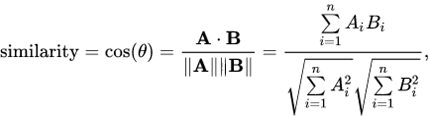

In [180]:
Image(url="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAa0AAAB1CAMAAADKkk7zAAAAaVBMVEX////l5eXBwcErKysAAAD6+vqoqKg5OTnz8/OEhIS+vr7u7u739/fa2trT09OhoaFPT0+Ojo7KyspaWlpkZGS4uLhqamqxsbGZmZlvb29+fn4hISEQEBAmJiZ0dHQ+Pj5HR0cYGBgyMjL2v28PAAARmUlEQVR4nO1dCXucKhQFBTcUxA3cl///Ix/gjEvGNpklyWvi+dqkmZmg9cjl3IUrACdOnDhx4sRLEJo/J/4JRDJKWI6/+zROfASkKl0Z9Ml3n8eJj4A4ZQaIa333eZz4EEgvQDJ6pyn8JxA1EPtpFH33eZz4ALAzAC+rOPzuEznxAeAgByDxz3XrxIkTvxMEQhhdADVOXfg/RpCmlX9BVaZx8VYXErr7MfTCUP/9ujM8sYJOqKQXWDIdkb9/Pyz77Y84kdyXDuMyOSfhNyAfx40WTAZ3z0KOpu1sw0mGms7hXTs6J11fD1yhfsMHTIPtu7BA7t4Ls8ZCf8ubfm8iT3wJSIwKb/0xEds3nWGw96xIxPW3YDzZ+hbQtmF/eisT8bijD5SNmXwl8k+l8S1wmvo4WYK5D7I9W9EwJR6kfOjOMNX3AHcoPrz2QUywj+T2pXycJJNpy0+N8V0gA6rI7cuwVBbSR5X+t8Xn1yTKckc4aa/tocUOfuvEZyOpx4NsiVMzwdKZLZHOk6lsjGHMGz0b2WkOvwVxdjtLoriqOj9FRrFfJEXUT0YKBrVLAT6t4bdAZAeTRBqaLBQD4Ak56/WgmeeYj0pMEn6K+G+AlR5cdmcw081CgyKpyuaIFDOaw5P1lADBJv/21058MpIs3/xkOMJWNWkvDLKyaStBnDjXL/o2cruyKlxNLxWx+MOIJz4NJN1q9MQwhy0upXoZSs4YzwEfwhDgoOqqMssqmZvgB09PkfHVwNmWLDoc5fth0R2U2KSc/tqFixwrrJAYfFqYB/Nq81Me20enEZWpcyMaSZo6v3VyifQwBRHyfojjwXXTrAoO3n8afHKsYAbjWY2qow+FiTjwx5JfSxYeUH8UGMB5ZyM0+FXnIvsTwj3J1A69wdDbNWqms7z6A0hG1Pxh7pTIxMipi+rX15BFQjhXCIXgjKx/ACVCuzTTClKgRl6+8y8+qxOHIG3WoPqwsnlhK0Xj6d/8L8BqGiMkj8yQZsuHMKrGkR9OvqeAq+0dgCNxTt93gYcsFM2xzlBsITdN4wbdVI+94sjddi0kvJhef4yfhkTph9BGzRoBgv71ntdzq1T62onr9BME2246Y8rb1x/ip6EcpRA9Qtli6nI0Xa6jZsvUTQiE0lcrtoTJvVcg6xcf4ecBtqNyeCaExiWSY/K2BleVAShC7YttYciZHQLJZzhqcp1svQs5OollWUpn8GXyLEvYwlaCkP3i4IFn8SEE1zp4fSv8BrbCzT1P7q9V6DPzLVc644CO2Tv2NJndoyf4J3iTWh7pzBX9P7CF6adHs6B/CUPQHIOI53//9BtEQ4saPWm6VnnIdr9X6aFvN8pC2m3doPb1mxcDGzqhuED/J9hXsOVxefsizn0CrGk8uiMJZy9bsT0/M2NFZVeqYznZXXmE0MotK1cD0EBZw/wt1ZF6dw67WvT17pZwfQq8GcRTV2VAX7BFEjb17SWC8egAT+rCgtvTHE31t3iFJrZcc2yYxV7eK8vSZf9MeQkJdroFR9T6fFMEvKq6vfFC1qlzge4RW1FnAged8/yxSVfqb5i3CYhiNbny/lNyGz8I4ZGVwPpF2B+xBTxNVpS+IPKW2MZ20DbTofRUR/SK50f9mQikk1AcJQkEUH0JBYMAm+SZelHP6pktyLjOnWH9mSjx1JRXqwApRk4j/VqivlL15S8H8gIpjZGAjmPMR+hwJ4m0jNIqEHNdF5mb6rvKff0K8xMQplxIm3tdbSehdO2u5IUrO99vfUD8VutTw1Zgp3k3CLWK2W3aTWVSjHEU8hq5Q0XEUNuVx9rmqLz4ChqnTjclSqTFjpP6ykuJufBtBkhm6/cjV+s6ZvYWOtPZzOAIeQPVuuErk9ZYgDhoikI6tsyL+ilUnnrjXNhiKFNSWQmLkKM4H1KI41aJoapmEAKPTq26vJN/IStI4xUX8RLGamhdwe/UCcbJJDF3FWOZBDA13pLVjGkajyZIJNyrgRWbke6TivcAs2E5ylD9f9PvQZMFEEYAd3o/ZqQ4AbC29dKhk0V5c51bJNAOjf6MUC6mdmALxRaQ7awH/CYH0RLiDuEGF+PoNEo+EOGRelA/ebFNeNNZUPn/0WBWKQd1hFita5Rme/UnvIOhAEm0Vn8ewUI/2RxlqcaB1msO8zQW2enFqBkzAsJSM0H1vj1YT1q8a7bEwhagVe+OOlPuXPZBG7Z4Pbs3SZ2B6k9bzjRwZar1le9r/AGvaCjsUVN3an65mi3s63lszUXjef3XLBGNW/sVqMu/HQWI/jWHeRqbcFreTWq2XNjSATXDFin2bAmdbaj0Z1gt92xF2v6lo5Utshtu7/3wytbM68JWotRGNjZcWULNUFjpA/pz5cTKFtzcYsl1VcTwRViWWbiecLD40OH7A3wNltO0ND3FBHA5JvpSLmylO7aiwVZvF7UMsFOzC1vRzFanJw1ren+x95T7Ky7T2FhCJTPhqNN1pK8hFwDTOFNsGQ/BryGg7ny359N13bKqdST+aS3KwnxzGPa/XLcwVQZaKCGGearmkq4YShBXtmq0jSWk+hIzXSs0KGs1UUD7tpKENbMlzJQvq0hyQKWnA+nRGvLB3gaXVYAMtpIojGOmb4tk5F7WKxegVNO6M+lW0VLcXYKyrE3+MtQnINwc5X9ZtIT56GOQt7FfDQmJ2yZ2pIvq0hpQU7CiaQbObdRy6jZNkTj1wLvUbjlrUZtZgJYjmnItE4u56LIb3rnzo9juulKtkNItK9cHXlmnfpZGelOanuqwjLP4MkbVP+lv/TORq49C93kItRgKAqLTFIRgXYTsYf0l9HQxcmgqkvXPxrLDkCrxbT6p7nnzTb2ceObi+O+GoDxqPqtWHcvSI0Qwys2qRntj90iQXG5rGL+f2dAaNVjduw09kCrvXr8T5rpI9uiXo0Tpykc3keI78IIhLmNgWL4oYpCoxSl73J/VlngHZ3o/Tpiq461lFliuDaMDP8QmDk5iDIiSK2EgRG5SGtZcDu8xBqj/0CoYOYw5HwcTB1sm7xviEvhRovxFe5Q5cuQzxV803vm9XvGBMOGerbxeawkDH2OTLyPaT1Q3AhzGRvkpjcJoHHjC5KNslZPbux/HlN4ehdV3DKDQC30jhtmrGpjTePCfElIi3d438mAP7w00UytbKULs+p/ZsQW13sTURjYOsceR8ee8x9lSVz+8C7dDSP7IEPCwVvIhPLvdGTsbbzj50HXcsRW1CA3X++WWLQAnZHQnbU2PrGfYelreE/+xtMX/SDjhu2+cHVuVzuZfPYgNW6Fh7IVsJc8vHvQ3bg3fsoXtMlv3LKxsDZb6q19SbNnalXJQo93vx9mS8mlhJn5jf6ctW05jJSO69hfZsQUb/ZJia6yqSjmRvjYoj7NV3lfgcwR5uB3vh2PLVjp4YFj2LPyBLc65P4ypbrn5OFvx88Ev/vIquX8AG7YipcsJX2oJj9ky61Y0oDZ/CVshhATCB8yi519TFTpoTB4Z4h/Ehq2qyaqqXHTGRmXAN2yFSsJnT7BFi6skZFlfVfEDRXrRtXRSuS1xxoffsYqtbOEplgrZdc/CThPu2cKKrfgJthx+lYS+0yageuBSB9cEOwj4IIH/O1pmrGyJ0dyttL7ojI0lTC5sRUoTms/EpiT+Ybb8JZ5AeBqCmN3vBMl12ZLK1U5/h+a4spXzqdFVj4lauFCmU2A3bHlO1aBGq4weNTpO8jBbG5ERc+WT/73I6xAbkVFkAPbsgbL/fw9Xtvxpcm2BgTO4vTvpcPDGEnqGLZjq4N5k23ZfmJXmYbbWrBBpLMBcIe42hXyJ2oR9BcTg57/BFO7jhFvsI0/NwSceZQuufe2ilABa+nfPC8jXegh1kpH/XID1X8FH2Tra8vEoW9b97NwM8T+uf/tE6IxJ/Be2tBPc6WzJwScezZj4zh2GLzx0pdhdvjH8KdRmyfz3FhbHmFuaLa53RBx8wmQjH6jJmedyqBPrlxKO45yIBhHcPzi9WRJibz/EH/qJJbJyfob3rBfn4wU6UkyZgkmd5T/M9IdUiUXrfqtmRAbhlWQzJPe76oYTDM2d0tHMvT0/qUWGEqnSWYaoqio/pDzPLFmL/1Gm5J9CaBLBpEfT5VrzMusblL65nlTXLOvSkqi+acQKfR1vIQWq+TyErLKh3jwIJRRMmHcSDKqBgP640fyJd3FRCFY7biLxYnjTryjMdBGmJ4Ty12/YSiqT3KI92qZf03EpQSLFiJpJeSWTTxLmgWH4De7YZ4BfgvwS2RvrF6X7Pnr5pYOA+nx/szSKah4ir7ctp8Jis9VRIhP2TQ2fif2C3Yy/E8XVVSpQvLnjKd+uOjDuL53a8vS2DExeK+85cjcpZMhWXlNkbgUfZUQ5eGfXqEexVGbBnSEDu0dFskLOfR6oYuAmp790dSUZ2tYKrY1k8TQ/XS1WU4w4OUh+RYz+9cBrHZ1VN39IIicxdHRSBlhxFfC36xbhyz4cvXQdyT3LdFAgvC68sMiE+Ej914lbJJuHjvD98wUXeB0HFkp10tEe3PhtEWu06c4gmvqIcY5SpRTTSa1Xge7/ys+59RAcud7mYbZpALaBVSjDiFzd+SYI5kLyLfJqc+19dKtC9LLV8crvUhYCqpt83B/lP6HRbadC5KIDv5UMKXP8OZd2BLktQoYpqm6GCKe5FVWKzoeAPoVhF7SQR11f2VQURYoOW8KbX9ptxszb29yzVc8LlY+6c8F6APR61XbF+l518MCYKE4IJMlck09WVQ6vPPOdIJcH8Xh+eRJeaiq4nFfVvv8WLE/Epbs+r1V3u/rjzjDouYYturQgIFeSol0LKHbUODZF5rfYvKaVD5QS/GpwdBHdawWNfvX2eVuEp9p6YeqPqNRWcvmENc4N+UC+tW7iNjsXOn6DOsl51s7JIHiSdRfg4hZVm2VfbDf6hLO5gmWaKtOGgzLLMgkidiWDdPoJXBoyW3/L2kU6EkOtx4ssK8uy6MxDT4hzBuDvA4+bi3+6SX0mu2nBZmWHiefp3aKeecYN4dW1O5YV15de2htJGGXbAKCoZva9+Qk5lxnIpf1p++J/JAhn9sUrGhaRQYutlmf2kZNLHD+7/ovHl03vchEZsNs9sms6DAcK4Z5s3QMPkn68NE+8Xjkv89XtD4nes52IYqwPpTa97sb1Ilg0ZiKtZbqeX0aeHgJDQoVvj8c7d+PzQYX3IkZzw5VrcVKYotpuFQa7tccGoeJwcZE9WeYcn4PA1jV0hTlqJjWC7U6tXashjjdDQJsebFs+8TeUsyhcG9M6jMkrGGPO4ZUOfZstMkKYOC8Q1xoRnOyH0IniA1j2XWU7J4CeGCbicJCs+iuoXJWIhWJNB7uzRyZh4mfU0HwhxGh8q/je/aeb6UJtIxfkvcvQqd/vRmLr5AhZRAaI3iQIrXeFWxTrZmPrk1UAfNNaJTlLZV6FvqG7GttdaxAcdPa7rVhIafplrfWmV/9qhlXVZ/XFq5BqUbjZHr4voIUCvb8X2fSfFWsA3ot2pRyiOWjGf+IhdFoUro2R8jeZkvBPSf8Nci0K2RJ3St5IPdKebL0KrKnCNbkl8t4C1uWhQLo6m3yALQsN4bqZP2eZD5LLCLrUF9YnW69CMKYQpFdJKJKaAnJ9KFD4MbaiaYq8pYKGirhahyD6gVQnW68Cbe2IlkvcScZ7J+gjbMF0tKJqccCcYe8OnGy9ED2izioyXCcIxcWKfdQSeiVykrW/YJlFEfU3lrD9WwPpE3chRbRcpEVkC58sfc8xiPLmA42blCgMFpFBikzQpZOzB0g+FtEZtXgRKsTWCppQyq2vhPNcivfLk5QoDNadZLm/4zcRzBGnf/wisKbcLDThPgzhhfjwgT17WKPNVw8Ykx29oYfxJ3Z4/mWw2vq2DOM+0AF9xtN7T9wCTujg4WT3DVGgc9vcF2FA8klDFfooe/9TJ16BDD39rD2Gzp1YXwR/erq5aj6dYfYvAsuerj2yjrtFnHg94M3WnvuHeKDhw4l/Gv8BnCgeUlxeEn4AAAAASUVORK5CYII=",
     width=500, height=500)


Попробуем посчитать косинусное расстояние между настоящими текстами. По заданию нужны 3 и 12666 тексты. В них обоих встречается слово "дебил", поэтому предположительно они должны оказаться более-менее близкими.

In [134]:
data.loc[3, 'comment']

'Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?\n'

In [135]:
data.loc[12666, 'comment']

'Это не параноик, это дебил\n'

В sklearn есть косинусное расстояние и косинусная близость. Близость это просто единица минус расстояние, то есть расстояние между близкими векторами должно быть маленькое (0 если совпадают 1 - если вообще не совпадают), а близость наоборот (1 если совпадают 0 если не совпадают совсем).

In [136]:
X[3]

<1x8433 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Row format>

In [137]:
# близость между 3 и 12666 текстами в датасете
cosine_similarity(X[3], X[12666])

array([[0.50771793]])

Близость получилась 0.51 (если окргулять), это совсем немного ближе к 1, чем к 0. Нельзя сказать, что тексты однозначно похожие, но тот факт, что и в том, и в том текстах встречается слово "дебил", сыграл роль.

#### Следующий пункт задания: б) найдите 3 самых близких текста к тексту номер 43; выведите сами тексты и значения близостей, а не только индексы этих текстов. 

Посмотрим, что за текст под номером 43:

In [138]:
data.loc[43, 'comment']

'Люди зажрались и охуели если по мнению этих игроков андромеда лучше Антема. Хотя че там с багаутом76 сравнивают вон... Вот оно че оказывается, игроки просто охуели, ну ок. Вот долбанные пидерасы, не хотят покупать такую отличную игру, а еще смеют ругать такой божественный геймплей. Баги, хуевый геймплей поправят, а контент, ну его запилят, через год другой, причем бесплатно! Ага. Стоит лишь потерпеть!\n'

Расстояние удобнее использовать, когда нужно отсортировать по близости, т.к в numpy по умолчанию сортируется по возрастанию.

Используем расстояние, чтобы найти три самых близких к 43-му текста.

In [142]:
# функция предназначена для расчета близости между массивами векторов
# и возвращает она тоже массив где каждая строчка это объект первого массива, 
# а каждая колонка это близость до объекта во втором массиве

# в нашем случае в первом массиве у нас только 1 вектор
# поэтому мы можем взять первую строчку из получившегося массива
# метод .argsort вернет список индексов по возрастанию 
# возьмем первые три индекса и посмотрим что там за тексты
cosine_distances(X[43], X).argsort()[0,:3]

array([   43,  2245, 14325], dtype=int64)

In [143]:
# первым нашелся этот же вектор
# а дальше уже не настолько близкие но все равно есть сходство
data.loc[[   43,  2245, 14325], 'comment'].values

array(['Люди зажрались и охуели если по мнению этих игроков андромеда лучше Антема. Хотя че там с багаутом76 сравнивают вон... Вот оно че оказывается, игроки просто охуели, ну ок. Вот долбанные пидерасы, не хотят покупать такую отличную игру, а еще смеют ругать такой божественный геймплей. Баги, хуевый геймплей поправят, а контент, ну его запилят, через год другой, причем бесплатно! Ага. Стоит лишь потерпеть!\n',
       'Че ты там мямлишь, утырок? Сопли подотри\n',
       'Ну оль, ну вот че тебе надо? Иди в по сри, а этот достопочтенный тред оставь в покое\n'],
      dtype=object)

Получилось, что первый самый близкий текст и есть сам 43-ий, поэтому возьмем первые 4 результата, а не первые 3, для чистоты эксперимента.

In [145]:
cosine_distances(X[43], X).argsort()[0,:4]

array([   43,  2245, 14325,  1957], dtype=int64)

Выведем сами тексты и значения косинусных близостей для каждого из этих текстов с нашим.

In [146]:
data.loc[[2245, 14325,  1957], 'comment'].values

array(['Че ты там мямлишь, утырок? Сопли подотри\n',
       'Ну оль, ну вот че тебе надо? Иди в по сри, а этот достопочтенный тред оставь в покое\n',
       'Че за бригада и че за махоун? Из полицейской академии?'],
      dtype=object)

In [148]:
# близость между топ-3 текстами с 43-им
print(cosine_similarity(X[43], X[2245]),
      cosine_similarity(X[43], X[14325]),
      cosine_similarity(X[43], X[1957]))

[[0.27934598]] [[0.25324249]] [[0.23279247]]


Теперь мы приступаем к обучению классификаторов, поэтому пора разделить датасет на test\train.

In [152]:
train, test = train_test_split(data, test_size=0.1, shuffle=True)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

## Задание 3.

Обучите 2 любых разных классификатора из семинара. Предскажите токсичность для текстов из 2ch_corpus.txt (второй семинар) и найдите 10 самых токсичных для каждого из классификаторов. Сравните получаемые тексты - какие тексты совпадают, какие отличаются, правда ли тексты токсичные?

*Можете предсказывать не все данные, но не менее 2500.

Требования к классификаторам:

а) один должен использовать CountVectorizer, другой TfidfVectorizer <br>
б) у векторазера должны быть вручную заданы как минимум 5 параметров <br>
в) у классификатора должно быть задано вручную как минимум 2 параметра <br>
г)  f1 мера каждого из классификаторов должна быть минимум 0.75


##### Первый классификатор будет использовать TfidfVectorizer. Начнем с векторизации и поиграем с парметарми.

Выше мы векторизовывали весь датасет `data`, теперь надо векторизовать по отдельности test и train.

Векторайзеры в sklearn имеют три основных метода **fit**, **transform** и **fit_transform**. 

**fit** - собирает словарь и статистики по текстам,   
**transform** - преобразует тексты в векторы, на основе уже собранного словаря.  
**fit_transform** - делает сразу и первое и второе (быстре чем 1 и 2 по очереди).

Для теста нам нужно векторизовать тексты тем же словарем, для этого вызовем метод .transform

In [278]:
vectorizer = TfidfVectorizer(strip_accents='unicode',
                             min_df=3,
                             max_features=13700,
                             max_df=0.7,
                             sublinear_tf=True)
X = vectorizer.fit_transform(train.comment)
X_test = vectorizer.transform(test.comment) 

max_features я подбирала в последнюю очередь, исходя из того, сколько слов оставалось после применения max_df \ min_df. И убрала с помощью max_features еще чуть больше ста слов сверх того, что убиралось и так. Остальные фичи подгоняла исходя из f1 score у knn ниже

In [217]:
X.shape

(12970, 13700)

In [218]:
X_test.shape

(1442, 13700)

Достанем отдельно целевую переменную.

In [162]:
y = train.toxic.values
y_test = test.toxic.values

In [163]:
# ! Называть матрицу с признаками X, а вектор с целевой переменной y - стандартная практика. 
# ! Если вы сделаете наоборот, то сильно запутаете меня в домашке 

Обучим первый классификатор. Результат ниже -- это результат после подбора всех фич у TfidfVectorizer.

In [222]:
clf = KNeighborsClassifier(n_neighbors=10, metric='cosine')
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       968
         1.0       0.78      0.66      0.71       474

   micro avg       0.82      0.82      0.82      1442
   macro avg       0.81      0.78      0.79      1442
weighted avg       0.82      0.82      0.82      1442



Теперь относительно этого результата можно еще поиграть с параметрами knn:

In [279]:
clf = KNeighborsClassifier(n_neighbors=19, metric='cosine', weights='distance')
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       968
         1.0       0.81      0.69      0.75       474

   micro avg       0.85      0.85      0.85      1442
   macro avg       0.84      0.81      0.82      1442
weighted avg       0.84      0.85      0.84      1442



Наиболее оптимальное количество соседей получается где-то в районе 17-22. Веса лучше сделать зависимыми от расстояния, так учитывается расстояние и между ближайшими соседями, что очень хорошо, так как мы в целом бьем в расстояние и с помощью метрики косинусного расстояния и с помощью весов.

##### Второй классификатор будет использовать CountVectorizer. Начнем с векторизации и поиграем с парметарми.


In [280]:
vectorizer_second = CountVectorizer()
X = vectorizer_second.fit_transform(train.comment)
X_test = vectorizer_second.transform(test.comment)

In [281]:
X.shape

(12970, 64046)

In [282]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

Слов получается в 6 раз больше, чем документов. Некоторые алгоритмы не смогут так обучиться (нужно чтобы признаки <= документы), а те что смогут будут обучаться сильно дольше.

In [340]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [347]:
from nltk.corpus import stopwords
russian_stops = stopwords.words("russian")
russian_stops = [word.replace('й','и') for word in russian_stops]
# судя по всему й меняется на и в strip_accents в векторайзере
# поэтому я заменила это и в своих стоп-словах тоже
print(russian_stops)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'еи', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'неи', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какои', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мои', 'тем', 'чтобы', 'нее', 'сеичас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другои', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [381]:
vectorizer_second = CountVectorizer(min_df=5,
                             max_df=0.7,
                             max_features=7400,
                             stop_words=russian_stops,
                             strip_accents='unicode')
X = vectorizer_second.fit_transform(train.comment)
X_test = vectorizer_second.transform(test.comment)

In [354]:
X.shape

(12970, 7400)

In [355]:
X_test.shape

(1442, 7400)

Достанем еще раз целевую переменную, чтобы не терялась:

In [286]:
y = train.toxic.values
y_test = test.toxic.values

Обучим второй классификатор, который использует частотности CountVectorizer. Буду использовать логрег, сначала хотела наивный байес, но передумала, потому что у него мало параметров, которые можно подкручивать.

In [380]:
clf_second = LogisticRegression(C=0.1, class_weight='balanced', solver='saga', max_iter=200)
clf_second.fit(X, y)
preds = clf_second.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87       968
         1.0       0.72      0.82      0.77       474

   micro avg       0.83      0.83      0.83      1442
   macro avg       0.81      0.83      0.82      1442
weighted avg       0.84      0.83      0.84      1442



liblinear дает ф1 скор ниже, чем saga, а saga не каждый раз сходится, хоть и дает чуть выше результат, поэтому я увеличила количество итераций, чтобы точно сходилась модель.

Окей, теперь у нас есть две обученных модели. Первая - это TfidfVectorizer + KNN, вторая модель - это CountVectorizer + Logit

**Теперь можно предсказать токсичность** для текстов из 2ch_corpus.txt. И найти 10 самых токсичных отдельно на первом, и отдельно на втором классификаторах.

In [228]:
# !!! двач не самое приятное место, большое количество текстов в этом корпусе токсичные
dvach = open('2ch_corpus.txt/2ch_corpus.txt', encoding='utf-8').read()

In [229]:
print("Длина ", len(dvach))

Длина  11638405


In [232]:
from nltk.tokenize import sent_tokenize
sentences_dvach = sent_tokenize(dvach)

In [233]:
len(sentences_dvach)

170507

Предскажем токсичность с помощью **первого** классификатора, который был TfidfVectorizer + Knn:

In [237]:
X_dvach = vectorizer.transform(sentences_dvach[:30000]) 

In [238]:
preds = clf.predict(X_dvach)

In [239]:
# predict_proba возвращает вероятности классов
probas = clf.predict_proba(X_dvach)

# в левой колонке вероятность 0 (нетокстичности)
# в правой - вероятность 1 (токсичности)
probas

array([[0.46773214, 0.53226786],
       [0.68301088, 0.31698912],
       [0.52631579, 0.47368421],
       ...,
       [0.89481309, 0.10518691],
       [0.63001628, 0.36998372],
       [0.63896952, 0.36103048]])

In [254]:
probas[:,1]

array([0.53226786, 0.31698912, 0.47368421, ..., 0.10518691, 0.36998372,
       0.36103048])

In [258]:
import numpy as np
best_ten = np.argsort(probas[:,1])[-10:]
best_ten

array([ 6896, 15170, 27628,  8553,  1186, 28995,  8538, 21274,  7815,
        5937], dtype=int64)

Таким образом мы можем напечатать топ-10 токсичных текстов:

In [386]:
for ind in best_ten[::-1]:
    print(sentences_dvach[ind])

Сука, какие же подростки тупые.
Фу чмо, игнорирую.
Пиздец!
На пистоне.
// Музыкальная академия, № 3, Москва, 1997.
Сука, тупые валенки, когда в вас вобьют хотя бы логический квадрат, блять.
Толстота какая.
К Подгороду, мразь.
Чому так?
И на Хоккайдо.


Тут не все тексты токсичные. Некоторые сюда попали как будто просто с редкими непонятными токенами, типа Хоккайдо, чому, №3 1997. Плюс тексты в топе оказались очень короткими. Возможно это как-то связано с тем, что это knn, и эта модель не учится, а запоминает слова, поэтому чем короче текст, тем больше шансов, что слова оттуда встретились при обучении.

Предскажем токсичность с помощью **второго** классификатора:

In [382]:
X_dvach = vectorizer_second.transform(sentences_dvach[:30000]) 

In [383]:
preds_second = clf_second.predict(X_dvach)

In [384]:
# predict_proba возвращает вероятности классов
probas_second = clf_second.predict_proba(X_dvach)

# в левой колонке вероятность 0 (нетокстичности)
# в правой - вероятность 1 (токсичности)
probas_second

array([[0.43326317, 0.56673683],
       [0.61994367, 0.38005633],
       [0.45684455, 0.54315545],
       ...,
       [0.53287672, 0.46712328],
       [0.63562728, 0.36437272],
       [0.40479598, 0.59520402]])

In [388]:
best_ten2 = np.argsort(probas_second[:,1])[-10:]
best_ten2

array([28337,  1131, 28643,  5470, 22051,  7237, 29611,  1238,   108,
       15985], dtype=int64)

In [390]:
for ind in best_ten2[::-1]:
    print(sentences_dvach[ind] + '\n')

Взрослая Шинобу блять, охуеть пиздец, откуда вы лезете нахуй, сука, ебаааааать, ВЗРОСЛАЯ ШИНОБУ)))) Ой бля все, сука пиздец, ну это уже край блять, А ТАМ ЧЕ С ХРОНОЛОГИЕЙ)))
  ВЛАДИК НЕ ПРОЕБАЛСЯ, ВЛАДИК НА РАБОТЕ ЗАЕБАЛСЯ.

самопочин
 Сука помогите пиздец глаз красный чешется я его чешу уже 2 часа ща сдохну нахуй пиздец как он чешется бляяяяядь
 Сука помогите пиздец глаз красный чешется я его чешу уже 2 часа ща сдохну нахуй пиздец как он чешется бляяяяядь
 Под струю воды сунь, ссунь.

В итоге дибил это то, кто такие задачи составляет
 Набежали хохлы дауны которы не смогли решить задачу, обиделись, и во всем виноват совок) хохлы - такие хохлы
 Хули не решаете быдло, блять?Успешными людьми стать можете.

И ничего, что вместо того, чтобы учить людей этим, блядь, трюкам, гораздо рациональнее было бы просто взять и НАПИСАТЬ, блядь, буквами, сука - ля бемоль мажор нахуй, нет блядь, нахуй нам писать, мы же МУЗЫКАНТЫ, у нас тут тайное знание ебаный в рот, хотим считать бемоли, придумывать трю

### Итого

Очевидно модель CountVectorizer + Logit сработала в разы лучше. Не очень понятно, почему это, возможно потому что тут убраны стопслова или просто логрег лучше, чем knn. Но топ-10 текстов от второй модели получились гораздо более токсичными.

## Анализ тональности 

Интуитивно кажется, что bag-of-words сильно упрощает - порядок слов ведь очень важен для текста! Однако на практике BOW работает необъяснимо хорошо. Начать решать практически любую классификационную нлп задачу лучше всего с мешка слов и просто алгоритма классификации. Это хорошее базовое решение, с которым удобно сравнивать более сложные решения и к тому же есть шанс, что уже такого базового решения будет достаточно для практического применения.

Попробуем такой подход в задаче определения тональности. Нужно предсказать является ли пост токсичным или нет.



Теперь попробуем обучить модель. Рассмотрим три простых алгоритма - метод ближайших соседей, логистическая регрессия, дерево решений и наивный байес.

Кратко идея этих алгоритмов:

1) **KNN** - это предсказания класса текста по близости к другим текстам, для которых известен класс. Выше мы считали близость между текстами косинусным расстоянием - в KNN делается то же самое, только рассматривается топ-K ближайших текстов. В KNN таким образом нет никакого обучения - просто запоминание тестовой выборки и сравнение с ней при предсказании.


2) **Логрег** - это по сути взвешенная сумма всех значения вектора. То есть мы берем вектор текста (с частотностями или с тфидф) и каждое число в нем домножаем на еще какой-то свой коэффициент, а затем складываем все и нормализуем. Если получившееся значение больше 0,5, то считаем, что этот текст "токсичный", а если нет, то "нейтральный". Коэффициенты подбираются на обучающих данных (это и есть обучение). Можно сказать, что в итоге для каждого слова находится показатель токсичности. Если в тексте будет много слов с высоким показателем токсичности, то весь текст будет отнесен к токсичному классу. Однако показатель токсичности не равно вероятность токсичности - он может быть равен любому числу (например, 0.282, -4815162342, 666.13) Интерпретировать значение показателя можно только по отношению к другим значениям. 

3) **Дерево решений** - это просто много вложенных if else. В процессе обучения подбирается такая серия условий типа "тфидф этого слова больше 1.23", чтобы в итоге получалось предсказать правильный класс текста. 

4) **Наивный байес** -  это тоже взвешенная сумма значений вектора, но коэффициенты здесь рассчитываются по-другому. В логреге взвешенная сумма - это одна цельная функция и параметры подбираются так, чтобы после умножения и суммы получались правильные предсказания. А в наивном байесе каждый коэффициент расчитывается отдельно без учета того, что вообще получится, если расчитать взвешенную сумму. Можно сказать, что в наивном байесе ничего и не обучается, а просто считаются статистики, из которых выводится вероятность каждого параметра (=слова) для конкретного класса. Вероятность расчитывается по формуле - количество раз, которое слово W встретилось в текстах данного класса разделить на общее количество слов, которые встретились в текстах данного класса. При предсказании взвешенная сумма (каждое значение в векторе умножается на вероятность этого слова) домножается на вероятность класса в целом. Она считается просто как количество примеров этого класса поделить на общее количество примеров.   
   *НБ логично использовать с абсолютными значениями частотностей, но он будет работать и с тфидф значениями. В этом случае, "количество раз, которое слово W встретилось в текстах данного класса" - это не количество раз, а сумма всех тфидф коэффициентов этого слова в текстах данного класса.*

У алгоритмов в sklearn стандартный интерфейс - есть функции fit, predict и predict_proba

In [36]:
clf = LogisticRegression(C=0.01, class_weight='balanced')

In [37]:
# fit обучает модель
clf.fit(X, y)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [38]:
clf.classes_

array([0., 1.])

In [39]:
# предикт предсказывает классы
preds = clf.predict(X_test)

In [40]:
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.85      0.84      0.85       948
        1.0       0.70      0.71      0.71       494

avg / total       0.80      0.80      0.80      1442



In [41]:
# predict_proba возвращает вероятности классов
# это полезно когда нужно подобрать порог например
probas = clf.predict_proba(X_test)

In [42]:
# в левой колонке вероятность 0 (нетокстичности)
# в правой - вероятность 1 (токсичности)
probas

array([[0.51740106, 0.48259894],
       [0.4963216 , 0.5036784 ],
       [0.46812591, 0.53187409],
       ...,
       [0.50655666, 0.49344334],
       [0.5004294 , 0.4995706 ],
       [0.50767687, 0.49232313]])

In [43]:
# возьмем вторую колонку
# проверим что она больше 0,85
# заменим True и False на 0 и 1 чтобы получить предсказания
preds = (probas[:,1]>0.85).astype(int)

In [44]:
# точность по токсичному классу сильно выросла но при этом упала полнота
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.66      1.00      0.79       948
        1.0       0.00      0.00      0.00       494

avg / total       0.43      0.66      0.52      1442



/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Попробуем другой классификатор

In [45]:
clf = MultinomialNB(alpha=1.)
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.81      0.98      0.89       948
        1.0       0.94      0.57      0.71       494

avg / total       0.86      0.84      0.83      1442



In [46]:
clf = DecisionTreeClassifier(max_depth=8, class_weight='balanced')
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.80      0.52      0.63       948
        1.0       0.45      0.76      0.56       494

avg / total       0.68      0.60      0.61      1442



In [50]:
clf = KNeighborsClassifier(n_neighbors=10, metric='cosine')
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.83      0.84      0.84       948
        1.0       0.69      0.67      0.68       494

avg / total       0.78      0.78      0.78      1442



У каждого из классификаторов есть свои параметры, которые нужно подбирать под задачу и под параметры векторизации. Значения параметров можно просто перебрать, но их может быть настолько много, что сделать это не получится, поэтому подбирать часто приходится вручную по интуиции. В документации есть достаточно подробное описание параметров, но понимать, какие значение нужно пробовать, вам поможет только практика!